## Clickbait Classification (Part 2)
 - Using Pretrained BERT for Sequence Classification Transformer

Dataset Source: https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

##### Import Necessary Libraries

In [0]:
import pandas as pd

import pyspark

from pyspark.sql.types import StructType, StructField, StringType, ArrayType
import pyspark.sql.functions as F

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

##### Versions of Libraries, Modules, Frameworks Used in This Project

In [0]:
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 4.2.4
Apache Spark version: 3.2.1


#### Define Functions Used in Project

##### Define Function to Ingest Dataset

In [0]:
def ingest_dataset(file_location: str, schema: StructType) -> pyspark.sql.dataframe.DataFrame:
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    
    dataset = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .schema(schema) \
      .load(file_location)
    
    dataset = dataset.na.drop(how='any')
    
    return dataset

##### Create Function to Display metrics

In [0]:
def metrics_eval(prediction: pd.Series, label: pd.Series, model_name: str, label_values: []) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
       & F1-score, among others)
    - Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
    
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print("-------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:")

    if label_values != []:
        report = classification_report(label, prediction, zero_division=1, target_names=label_values)
    else:
        report = classification_report(label, prediction, zero_division=1)
    print(report)

    print("-------------------------------------------------------------")

    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    
    if label_values != []:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    else:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()

    print("-------------------------------------------------------------")

#### Data Ingestion & Preprocessing

##### Ingest Dataset

In [0]:
data_file = "/FileStore/tables/clickbait_data.csv"

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("labels", StringType(), True),
])

df = ingest_dataset(data_file, orig_schema)

df.printSchema()

root
 |-- text: string (nullable = true)
 |-- labels: string (nullable = true)



##### Data Preprocessing

In [0]:
df = df.filter(F.col("labels").isin([0, 1]))

df = df.withColumn("text_len", F.size(F.split(F.col("text"), " ")))

display(df)

text,labels,text_len
Should I Get Bings,1,4
Which TV Female Friend Group Do You Belong In,1,9
"""The New """"Star Wars: The Force Awakens"""" Trailer Is Here To Give You Chills""",1,14
"""This Vine Of New York On """"Celebrity Big Brother"""" Is Fucking Perfect""",1,12
A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor,1,18
How To Flirt With Queer Girls Without Making A Total Fool Of Yourself,1,13
32 Cute Things To Distract From Your Awkward Thanksgiving,1,9
If Disney Princesses Were From Florida,1,6
What's A Quote Or Lyric That Best Describes Your Depression,1,10
"""Natalie Dormer And Sam Claflin Play A Game To See How They'd Actually Last In """"The Hunger Games""""""",1,18


Output can only be rendered in Databricks

Output can only be rendered in Databricks

##### Data Preprocessing (Part 2)

In [0]:
df = df.replace({'0' : 'Normal', '1' : 'Clickbait'}, subset=['labels'])

df = df.drop("text_len")

print(f"There are {df.count()} samples in this dataset.")
df.printSchema()

There are 31928 samples in this dataset.
root
 |-- text: string (nullable = true)
 |-- labels: string (nullable = true)



In [0]:
display(df)
df = df.persist()

text,labels
Should I Get Bings,Clickbait
Which TV Female Friend Group Do You Belong In,Clickbait
"""The New """"Star Wars: The Force Awakens"""" Trailer Is Here To Give You Chills""",Clickbait
"""This Vine Of New York On """"Celebrity Big Brother"""" Is Fucking Perfect""",Clickbait
A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor,Clickbait
How To Flirt With Queer Girls Without Making A Total Fool Of Yourself,Clickbait
32 Cute Things To Distract From Your Awkward Thanksgiving,Clickbait
If Disney Princesses Were From Florida,Clickbait
What's A Quote Or Lyric That Best Describes Your Depression,Clickbait
"""Natalie Dormer And Sam Claflin Play A Game To See How They'd Actually Last In """"The Hunger Games""""""",Clickbait


#### Setup & Train Model

##### Build Pipeline Stages

In [0]:
doc_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

sequence_clf = BertForSequenceClassification.pretrained("bert_classifier_base_cased_clickbait_news","en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("class")

bert_classifier_base_cased_clickbait_news download started this may take some time.
Approximate size to download 387.6 MB
[OK!]


##### Build Pipeline

In [0]:
clickbait_clf_pipeline = Pipeline().setStages([
    doc_assembler, 
    tokenizer, 
    sequence_clf
])

##### Fit Pipeline to Training Dataset

In [0]:
clf_model = clickbait_clf_pipeline.fit(df)

#### Evaluate Model

##### Inference: Predictions Using Testing Dataset

In [0]:
preds = clf_model.transform(df)

##### Prepare Predictions for Metrics Evaluation Function

In [0]:
condensed_preds = (preds.select(F.col("labels").alias("ground_truth"), F.col("class.result").alias("predictions"))).toPandas()

condensed_preds["predictions"] = condensed_preds["predictions"].apply(lambda x : x[0])

display(condensed_preds)

ground_truth,predictions
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait
Clickbait,Clickbait


##### Display Metrics

-------------------------------------------------------------
The Clickbait CLF (Bert Pretrained) Model:
-------------------------------------------------------------
Classification Report for the Clickbait CLF (Bert Pretrained) Model:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     16007
   Clickbait       0.99      1.00      1.00     15921

    accuracy                           1.00     31928
   macro avg       1.00      1.00      1.00     31928
weighted avg       1.00      1.00      1.00     31928

-------------------------------------------------------------
Confusion Matrix for the Clickbait CLF (Bert Pretrained) Model:
-------------------------------------------------------------


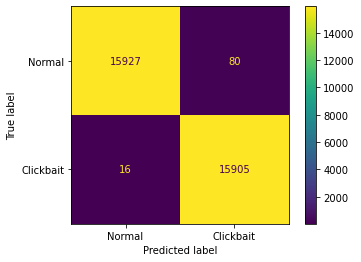

In [0]:
labels_converter = ["Normal", "Clickbait"]
metrics_eval(condensed_preds["ground_truth"], \
             condensed_preds["predictions"], \
             "Clickbait CLF (Bert Pretrained)", \
             label_values=labels_converter)

##### End Spark Session

In [0]:
df.unpersist()

spark.stop()

### Notes & Other Takeaways From This Project
***
- Wow! The model is nearly perfect! While the 97%+ accuracy, f1-score, precision, and recall for the initial model was stellar, this is even better.
***
- Since I am using a pretrained model, I used the whole dataset for evaluation.
***
- I am curious to see the third (and final) model to see how it compares.